In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
MAX_ITERATIONS = 80

def mandelbrot_like(a,b,parameter):
    c = complex(a,b)
    z = 0
    n = 0
    while abs(z) <= 2 and n < MAX_ITERATIONS:
        aux = z - parameter
        z = aux*aux + c
        n += 1
    color_pixel = 1.0 - (n / MAX_ITERATIONS)
    return color_pixel

# Obtain a matrix filled with the color values of a Mandelbrot-like fractal
# Inputs:
# start_a, end_a, num_a = starting value, ending value, and number of values
#      for the real part of the complex number
#      z_0 = a + b*i that initiates the succession of complex numbers
# start_b, end_b, num_b = starting value, ending value, and number of values
#      for the imaginary part of the complex number
#      z_0 = a + b*i that initiates the succession of complex numbers
# parameter = real number between 0 and 1 that is used to obtain different fractals,
#        all of which are similar to Mandelbrot's. The value parameter == 0 yields
#        the original Mandelbrot fractal
# Output:
# matrix = ndarray of shape (num_a, num_b) which contains
#      floats between 0 and 1 that indicate how many terms the
#        succession of complex numbers takes to diverge: 0 indicates that it does
#        not diverge before MAX_ITERATIONS terms; 1 indicates that it diverges
#        immediately, i.e. at the second term
def mandelbrot_matrix(start_a, end_a, num_a, start_b, end_b, num_b, parameter):
  values_a = np.linspace(start_a, end_a, num_a)
  values_b = np.linspace(start_b, end_b, num_b)
  matrix = np.zeros((values_a.size, values_b.size))
  for index_a, a in enumerate(values_a):
      for index_b, b in enumerate(values_b):
          matrix[index_a, index_b] = mandelbrot_like(a, b, parameter)
  return matrix


# Obtain a binary classification dataset based on a Mandelbrot-like fractal
# Inputs:
# start_a, end_a = starting value and ending value
#      for the real part of the complex number
#      z_0 = a + b*i that initiates the succession of complex numbers
# start_b, end_b = starting value and ending value
#      for the imaginary part of the complex number
#      z_0 = a + b*i that initiates the succession of complex numbers
# parameter = real number between 0 and 1 that is used to obtain different fractals,
#        all of which are similar to Mandelbrot's. The value parameter == 0 yields
#        the original Mandelbrot fractal
# num_samples = number of samples to obtain
# Output:
# matrix = ndarray of shape (num_samples, 2) which contains
#      floats between 0 and 1 that indicate how many terms the
#        succession of complex numbers takes to diverge: 0 indicates that it does
#        not diverge before MAX_ITERATIONS terms; 1 indicates that it diverges
#        immediately, i.e. at the second term
def mandelbrot_classification(start_a, end_a, start_b, end_b, parameter, num_samples):
  input_values = np.zeros((num_samples, 2))
  input_values[:, 0] = np.random.uniform(start_a, end_a, size=(num_samples,) )
  input_values[:, 1] = np.random.uniform(start_b, end_b, size=(num_samples,) )
  output_values = np.zeros((num_samples, ))
  for ndx in range(num_samples):
    output_values[ndx] = mandelbrot_like(input_values[ndx, 0], input_values[ndx, 1], parameter) > 0.5
  return input_values, output_values

In [ ]:
def negative_false_positives(clf, X, y):
     y_pred = clf.predict(X)
     cm = confusion_matrix(y, y_pred)
     return -cm[0,1]

def negative_false_negatives(clf, X, y):
     y_pred = clf.predict(X)
     cm = confusion_matrix(y, y_pred)
     return -cm[1,0]

# Ejercicio 1 y 2
Genera conjuntos de datos

In [ ]:
np.random.seed(42)
X_train, y_train = mandelbrot_classification(-1, 1, -1, 1, 0, 1000)

Entrenar modelos

In [ ]:
#Hyper parameters
numeros_de_vecinos = [1, 2, 5, 10, 20, 50, 100] #mlp
parametro_gamma = [0.001, 0.01, 0.1, 1, 10, 100] #svr
crossValidationNum = 10
#Prepare arrays for model metrics
kneighbours_models_num = len(numeros_de_vecinos)
kneighbours_auc = np.zeros((kneighbours_models_num, crossValidationNum))
kneighbours_accuracy = np.zeros((kneighbours_models_num, crossValidationNum))
kneighbours_false_positives = np.zeros((kneighbours_models_num, crossValidationNum))
kneighbours_false_negatives = np.zeros((kneighbours_models_num, crossValidationNum))

svc_models_num = len(parametro_gamma)
svc_auc = np.zeros((svc_models_num, crossValidationNum))
svc_accuracy = np.zeros((svc_models_num, crossValidationNum))
svc_false_positives = np.zeros((svc_models_num, crossValidationNum))
svc_false_negatives = np.zeros((svc_models_num, crossValidationNum))

KNeighbours classifier

In [ ]:
for idx, numero_de_vecinos in enumerate(numeros_de_vecinos):
  kneighbours = KNeighborsClassifier(
    n_neighbors = numero_de_vecinos
  )
  kf = KFold(n_splits=10, shuffle=True, random_state=42)

  scoring = {
    'auc': 'roc_auc',
    'accuracy': 'accuracy',
    'neg_fp': negative_false_positives,
    'neg_fn': negative_false_negatives
  }

  # 5. Run Cross-Validation
  results = cross_validate(kneighbours, X_train, y_train, cv=kf, scoring=scoring)
  # 6. Extract and Convert Results (Flip negative signs to positive)
  kneighbours_auc[idx] = results['test_auc']
  kneighbours_accuracy[idx] = results['test_accuracy']
  kneighbours_false_positives[idx]  = -results['test_neg_fp']
  kneighbours_false_negatives[idx]  = -results['test_neg_fn']


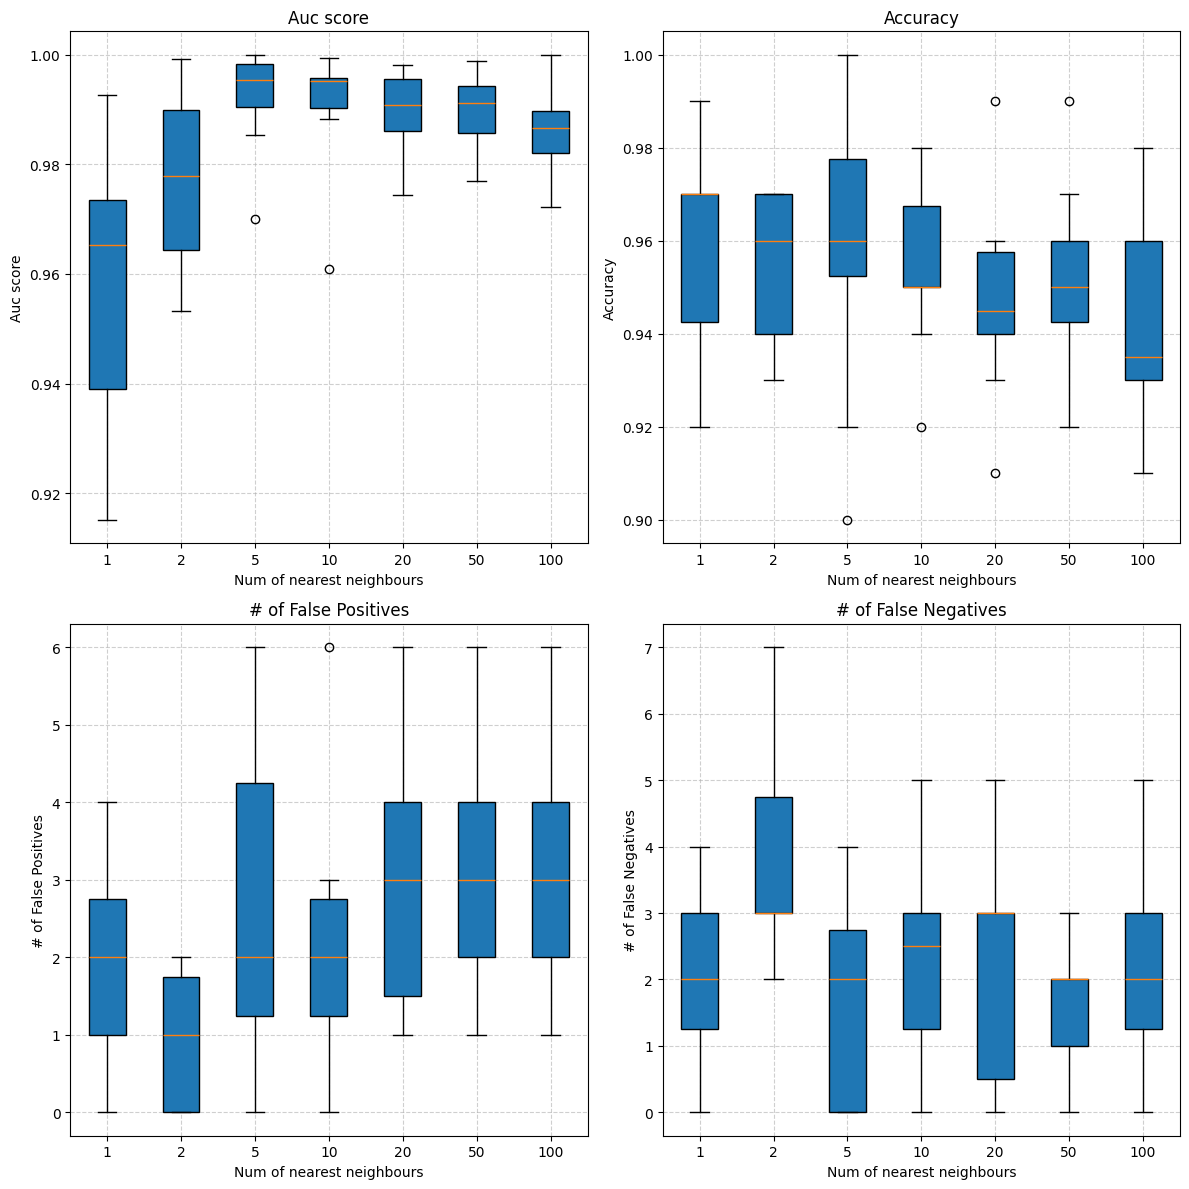

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
metrics_data = [
    (kneighbours_auc, 'Auc score'),
    (kneighbours_accuracy, 'Accuracy'),
    (kneighbours_false_positives, '# of False Positives'),
    (kneighbours_false_negatives, '# of False Negatives')
]

for ax, (data, title) in zip(axes.ravel(), metrics_data):
    ax.boxplot([row for row in data], patch_artist=True)
    ax.set_title(title)
    ax.set_xlabel('Num of nearest neighbours')
    ax.set_ylabel(title)
    ax.set_xticklabels([numero_de_vecinos for numero_de_vecinos in numeros_de_vecinos])
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

El rendimiento del modelo es muy bueno para todos los números que hemos usado como parámetro(accuracy > 0.9 y auc > 0.9). Obtenemos el mejor rendimiento cuando el parámetro es igual a 5 con media exactitud = .96 y medio auc superior a 0.99.

El buen rendimiento se ve también en el hecho que los falsos positivos y los falsos negativos forman solo un pequeño porcentaje del conjunto de validación(tamaño de 100)

SVC

In [ ]:
for idx, gamma in enumerate(parametro_gamma):
  svc = SVC(
    C = 1,
    kernel = 'rbf',
    gamma = gamma
  )
  kf = KFold(n_splits=10, shuffle=True, random_state=42)

  scoring = {
    'auc': 'roc_auc',
    'accuracy': 'accuracy',
    'neg_fp': negative_false_positives,
    'neg_fn': negative_false_negatives
  }

  # 5. Run Cross-Validation
  results = cross_validate(svc, X_train, y_train, cv=kf, scoring=scoring)
  # 6. Extract and Convert Results (Flip negative signs to positive)
  svc_auc[idx] = results['test_auc']
  svc_accuracy[idx] = results['test_accuracy']
  svc_false_positives[idx]  = -results['test_neg_fp']
  svc_false_negatives[idx]  = -results['test_neg_fn']


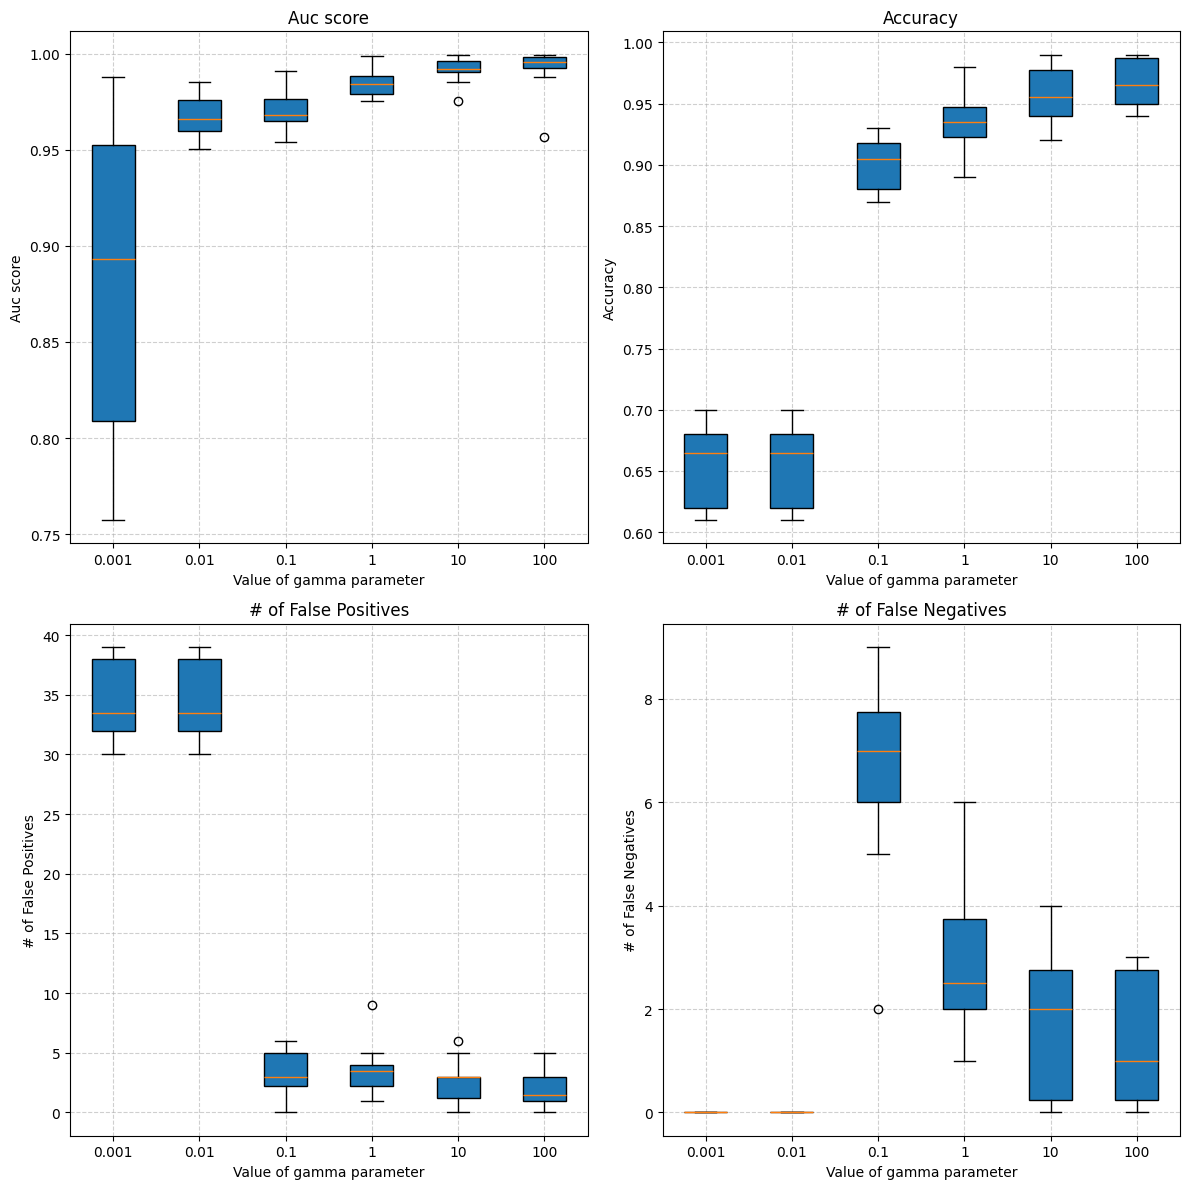

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
metrics_data = [
    (svc_auc, 'Auc score'),
    (svc_accuracy, 'Accuracy'),
    (svc_false_positives, '# of False Positives'),
    (svc_false_negatives, '# of False Negatives')
]

for ax, (data, title) in zip(axes.ravel(), metrics_data):
    ax.boxplot([row for row in data], patch_artist=True)
    ax.set_title(title)
    ax.set_xlabel('Value of gamma parameter')
    ax.set_ylabel(title)
    ax.set_xticklabels([gamma for gamma in parametro_gamma])
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

El rendimiento del modelo se mejora cuando el valor del parámetro gamma se va aumentando, alcazando muy buen rendimiento para valores iguales a 1, 10 y 100(exactitud > 0.9, auc > 0.95). El mejor rendimiento se obtiene para gamma = 100 pero tenemos que observar que entre 1 y 100 la diferencia no es considerable.

En comparación con el modelo knearestneighbors, se ve que el rendimiento de las mejores variaciones de los dos modelos es similar. No obstante, el comportamiento de kneearest neighbours es muy bueno independientemente del valor del parámetro mientras que, hay valores gamma para los cuales el rendimiento de svc es mucho más bajo

# Ejercicio 3 y 4
Mejor modelo: Knearest neighbours nearest_neighbours = 5

Peor modelo: SVC gamma = 0.001

Mejor modelo

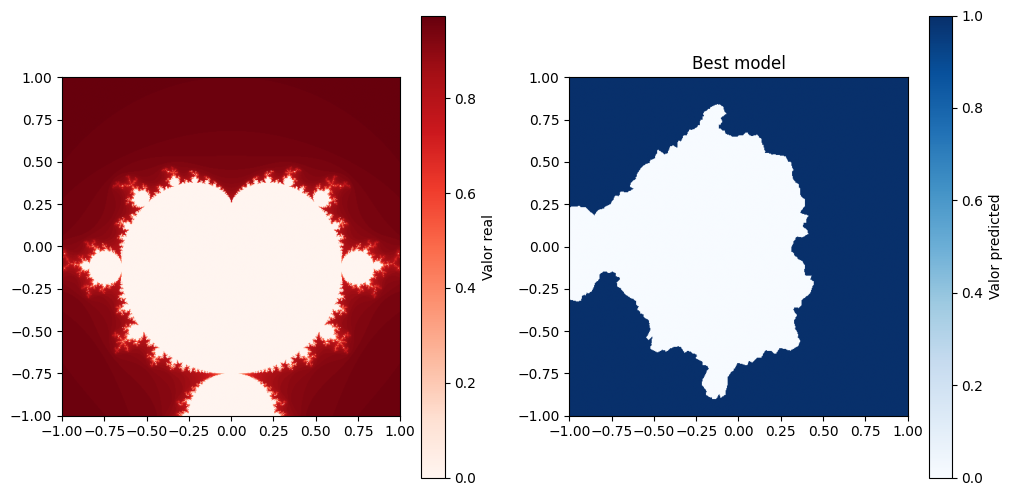

<Figure size 640x480 with 0 Axes>

In [ ]:
x = np.linspace(-1, 1, 500)
y = np.linspace(-1, 1, 500)
xv, yv = np.meshgrid(x, y)
z_real = mandelbrot_matrix(-1, 1, 500, -1, 1, 500, 0)

best_model = KNeighborsClassifier(
    n_neighbors = 5
)
best_model.fit(X_train, y_train)
z_best_predictions = best_model.predict(np.column_stack((xv.ravel(), yv.ravel()))).reshape(500, 500)

plot_extent = (x.min(), x.max(), y.min(), y.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

mappableReal = axes[0].imshow(z_real, cmap='Reds', origin='lower', extent=plot_extent)

mappablePredicted = axes[1].imshow(z_best_predictions, cmap='Blues', origin='lower', extent=plot_extent)

plt.colorbar(mappableReal, ax=axes[0], label='Valor real')

plt.colorbar(mappablePredicted, ax=axes[1], label='Valor predicted')

plt.title('Best model')

plt.show()

plt.tight_layout()

Peor modelo

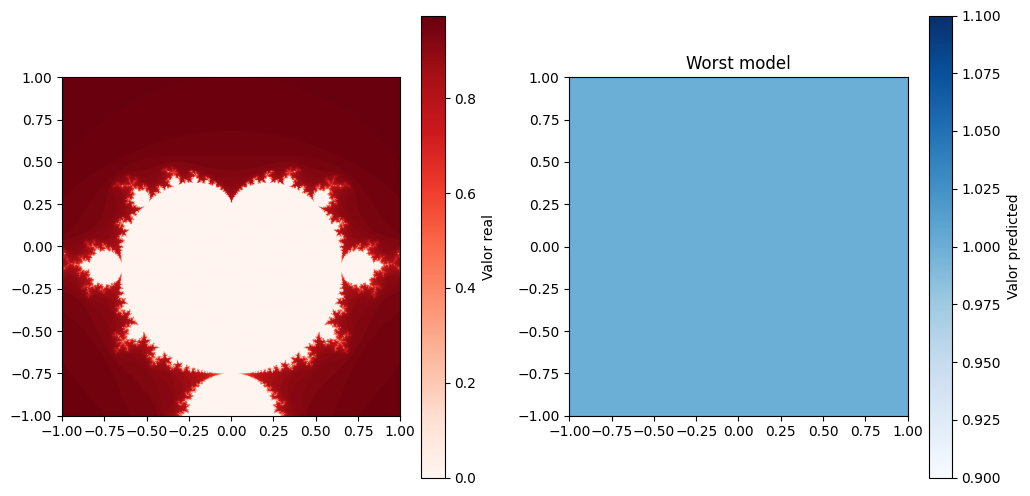

<Figure size 640x480 with 0 Axes>

In [ ]:
x = np.linspace(-1, 1, 500)
y = np.linspace(-1, 1, 500)
xv, yv = np.meshgrid(x, y)
z_real = mandelbrot_matrix(-1, 1, 500, -1, 1, 500, 0)

worst_model = SVC(
    C = 1,
    kernel = 'rbf',
    gamma = 0.001
  )

worst_model.fit(X_train, y_train)
z_best_predictions = worst_model.predict(np.column_stack((xv.ravel(), yv.ravel()))).reshape(500, 500)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

mappableReal = axes[0].imshow(z_real, cmap='Reds', origin='lower', extent=plot_extent)

mappablePredicted = axes[1].imshow(z_best_predictions, cmap='Blues', origin='lower', extent=plot_extent)

plt.colorbar(mappableReal, ax=axes[0], label='Valor real')

plt.colorbar(mappablePredicted, ax=axes[1], label='Valor predicted')

plt.title('Worst model')


plt.show()

plt.tight_layout()

El mejor modelo logra encontrar la clase corecta casi cada vez y eso se confirme en el colormap. Podemos ver que en su mayor parte el color es el mismo que el valor real. Además, podemos ver que su comportamiento es muy similar a los modelos que habíamos usado para la regresión de la misma función.

El peor modelo parece que simplemente supone que todas sus entradas pertenecen a la clase 1 y así podemos entender mejor su bajo rendimiento

# Ejercicio 5
Ya tenemos rendimientos muy buenos de los modelos knearestneighbour y svc. Por consiguiente, intetaremos conseguir similares o mejores rendimientos usando otros modelos. Concretamente vamos a usar randomforestclassifier y  mlpclassifier

In [ ]:

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.01]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
best_rf_score = grid_rf.best_score_

grid_mlp = GridSearchCV(MLPClassifier(max_iter=3000, random_state=42), mlp_params, cv=5, scoring='roc_auc', n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_mlp = grid_mlp.best_estimator_
best_mlp_score = grid_mlp.best_score_

print(f"Random forest | Params: {grid_rf.best_params_}")
print(f"Random Forest AUC: {best_rf_score:.5f}")
print(f"MLP | Params: {grid_mlp.best_params_}")
print(f"MLP AUC: {best_mlp_score:.5f}")


Random forest | Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest AUC: 0.99000
MLP | Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'solver': 'lbfgs'}
MLP AUC: 0.99389


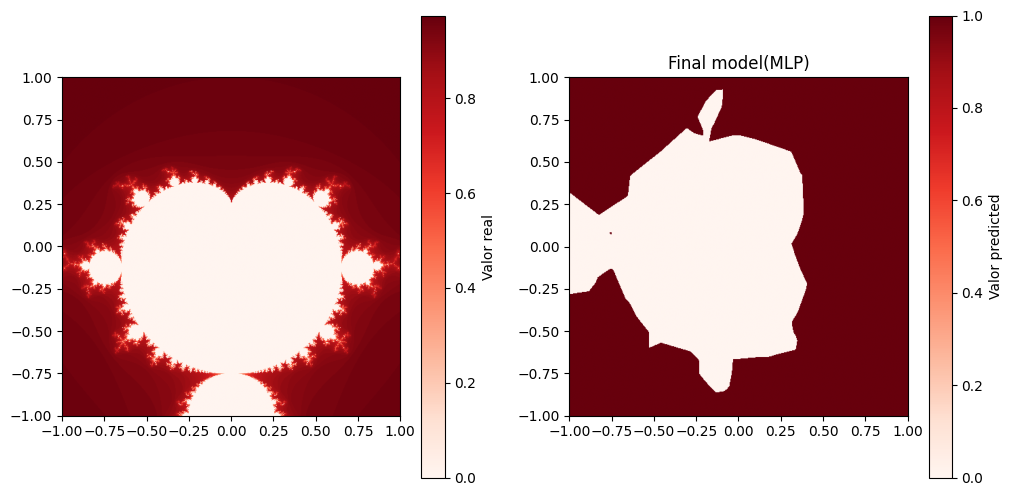

Original models auc
SVC original best auc 0.9916679458265844
Kneighbours original best auc 0.9923299917518122
Final model auc
Mlp final auc 0.9938931297709923


<Figure size 640x480 with 0 Axes>

In [ ]:
z_final_predictions = best_mlp.predict(np.column_stack((xv.ravel(), yv.ravel()))).reshape(500, 500)
plot_extent = (x.min(), x.max(), y.min(), y.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
mappableReal = axes[0].imshow(z_real, cmap='Reds', origin='lower', extent=plot_extent)
mappablePredicted = axes[1].imshow(z_final_predictions, cmap='Reds', origin='lower', extent=plot_extent)
plt.colorbar(mappableReal, ax=axes[0], label='Valor real')
plt.colorbar(mappablePredicted, ax=axes[1], label='Valor predicted')
plt.title('Final model(MLP)')

plt.show()

plt.tight_layout()

print('Original models auc')
print('SVC original best auc', np.mean(svc_auc[5]))
print('Kneighbours original best auc', np.mean(kneighbours_auc[2]))
print('Final model auc')
print('Mlp final auc', best_mlp_score )

Se observa en el colormap que el modelo seleccionado tiene un rendimiento muy bueno. Además, vemos que el auc es similar a los aucs de los modelos anteriores

Calcular y comparar otros métricos de los mejores modelos en nueva muestra

In [ ]:
np.random.seed(150)
X_test, y_test = mandelbrot_classification(-1, 1, -1, 1, 0, 1000)
best_mlp_pred = best_mlp.predict(X_test) #mlp
best_kneighbours_pred = best_model.predict(X_test) #5 neighbours
best_svc = SVC(
    C = 1,
    kernel = 'rbf',
    gamma = 100
  )
best_svc.fit(X_train, y_train)
best_svc_pred = best_svc.predict(X_test)

print('Best kneighbours accuracy: ', accuracy_score(y_test, best_kneighbours_pred))
print('Best SVC accuracy: ', accuracy_score(y_test, best_svc_pred))
print('Best MLP accuracy: ', accuracy_score(y_test, best_mlp_pred))

Best kneighbours accuracy:  0.946
Best SVC accuracy:  0.947
Best MLP accuracy:  0.956


Tanto el AUC como la exactitud son superiores en el MLP que en los otros modelos pero no hay mucha diferencia, algo que esperabamos porque tanpoco hay mucho margen de mejoramiento